- AlexNet beat conventional computer vision models
- VGG starts contructing deep networks stacking the same blocks
- NiN added local nonlinearity with 1x1 convs and used globalavg
- GoogLeNet is a multi-branch net which concatenates parallel transformations
- ResNet is a 2-branch subnet using Identity mapping in one branch
- DenseNet generalizes the ResNet architecture
- AnyNet adopts the paradigm of neural architecture search

In [ ]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
import Famous_Models as FM
from torch import nn
from torch.nn import functional as F
import torch

train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))



rm: cannot remove '/content/Learning': No such file or directory
Cloning into 'Learning'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 144 (delta 79), reused 105 (delta 46), pack-reused 0
Receiving objects: 100% (144/144), 1.42 MiB | 1.20 MiB/s, done.
Resolving deltas: 100% (79/79), done.


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

60000 10000 375 94 79


steam and head are kept fixed.

FOr any stage i the design choices are the bottleneck ratio b_i and the numebr of broups g_i block width w_i and depth d_i.

The error empirical distribution function is used to estimate the goodness of the choices. It measures the numer of models with errors e_i lower than e.

The final results lead to:
- share the bottleneck ration across stages b_i=b
- share the number of groups across stages g_i=g
- increase net widht across stages w_i<=w_i+1
- increase net depth across stages d_i<=d_i+1 (how many resnext we put)

In [ ]:
class AnyNet(FFL.Classifier):

    def stem(self, num_channels):
        return nn.Sequential(nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
                             nn.LazyBatchNorm2d(), nn.ReLU())
    
    def stage(self, depth, num_channels, groups, bot_mul):
        blk = []
        for i in range(depth):
            if i==0:
                blk.append(FM.ResNeXtBlock(num_channels, bot_mul, groups, use_1x1conv=True, strides=2))
            else:
                blk.append(FM.ResNeXtBlock(num_channels, bot_mul, groups))
        return nn.Sequential(*blk)

    def __init__(self, arch, stem_channels, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.stem(stem_channels))
        for i, s in enumerate(arch):
            self.net.add_module(f'stage{i+1}', self.stage(*s))
        self.net.add_module('head', nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                                  nn.Flatten(), nn.LazyLinear(num_classes)))
        

class RegNet32(AnyNet):
    def __init__(self, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(((depths[0], channels[0], groups, bot_mul),
                          (depths[1], channels[1], groups, bot_mul)),
                          stem_channels, num_classes)



In [ ]:
model, loss_f = FFL.get_model(RegNet32(), (1, 1, 96, 96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


X output shape:	 torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])

Number of parameters: 1451290


In [ ]:
train_loss, val_loss, acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.05, epochs=10)

Epoch: 0, loss = 0.509077, v_loss = 0.348368, accuracy = 0.864517
Epoch: 1, loss = 0.28054, v_loss = 0.295805, accuracy = 0.878758
Epoch: 2, loss = 0.22346, v_loss = 0.252024, accuracy = 0.892207
Epoch: 3, loss = 0.186824, v_loss = 0.247484, accuracy = 0.888944
Epoch: 4, loss = 0.15483, v_loss = 0.223072, accuracy = 0.894383
Epoch: 5, loss = 0.12726, v_loss = 0.21429, accuracy = 0.892702
Epoch: 6, loss = 0.106319, v_loss = 0.184792, accuracy = 0.899328
Epoch: 7, loss = 0.0902692, v_loss = 0.236741, accuracy = 0.886669
Epoch: 8, loss = 0.0794306, v_loss = 0.250524, accuracy = 0.88123
Epoch: 9, loss = 0.0631478, v_loss = 0.144061, accuracy = 0.898438


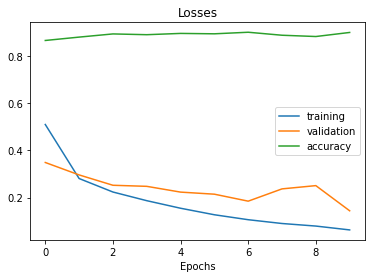

prediction comparison:

 tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  Tr

In [ ]:
FFL.after_training_plots(train_loss, val_loss, acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/RegNet32_trained.pt")
#model.load_state_dict(FFL.torch.load("/content/Learning/RegNet32_trained.pt"))